In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer

# Festlegen der Größe einer Abbildung in Seaborn
sns.set(rc={"figure.figsize":(20,10)})

In [116]:
# Import der csv-Datei mit JIRA-Export.xlsx als Dataframe
data = pd.read_excel("JIRA-Export.xlsx")

# Die ersten fünf Zeilen des Dataframes
data.head()

,Schlüssel,Zusammenfassung,Ursprüngliche Schätzung,Verbleibende Schätzung,Benötigte Zeit,Priorität,Beschreibung
0,MDK-12997,QP Pflege SGB XI - Prüfbericht(Produktergebnis...,14400.0,0,43200,Medium,Frage 3.5 (E Frage) wurde im EHB Einrichtung a...
1,MDK-12996,QPs - Stichprobenziehung Kurzzeitpflege - Akti...,14400.0,0,11700,Medium,"Ist: \n\nBogen ""Stichprobenziehung Kurzzeitpfl..."
2,MDK-12993,QPs - EHB Stichprobenbildung ohne Ergebniserfa...,14400.0,0,19800,Medium,"IST: \nWird im EHB ""Stichprobenbildung ohne Er..."
3,MDK-12991,Schneller Wechsel zwischen Aufträgen unterschi...,14400.0,0,52200,Medium,Getestet gegen QA als michael_meier. Ein schne...
4,MDK-12990,[UI] Modaldialog Mitarbeiter löschen verkrafte...,14400.0,0,8100,Medium,Siehe Screenshot


Das Notebook ist in folgende zwei Bereiche unterteilt: 

1. EDA
2. Textbasierte EDA

# 1. EDA

Hier werden alle Variablen außer "Zusammenfassung" und "Beschreibung" analysiert. 

In [117]:
# Ausgabe der Dimensionalität des DataFrames anhand eines Tupels.
data.shape

(4429, 7)

In [118]:
# Ausgabe von Infos zum Dataframe, wie z.B. Spaltennamen, dessen Dtype und Anzahl der Nicht-Null-Werte.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4429 entries, 0 to 4428
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Schlüssel                4429 non-null   object 
 1   Zusammenfassung          4429 non-null   object 
 2   Ursprüngliche Schätzung  4350 non-null   float64
 3   Verbleibende Schätzung   4429 non-null   int64  
 4   Benötigte Zeit           4429 non-null   int64  
 5   Priorität                4429 non-null   object 
 6   Beschreibung             4393 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 242.3+ KB


In [119]:
# Gegenprobe mit Fazit, dass zwei Spalten leere Werte enthalten
data.isnull().sum()

Schlüssel                   0
Zusammenfassung             0
Ursprüngliche Schätzung    79
Verbleibende Schätzung      0
Benötigte Zeit              0
Priorität                   0
Beschreibung               36
dtype: int64

In [120]:
# Im Folgenden sollen die Zeilen rausgefiltert werden, dessen Beschreibung oder ursprüngliche Schätzung leer ist.
data = data[data["Ursprüngliche Schätzung"].notnull()]
data = data[data["Beschreibung"].notnull()]

# Überprüfung
data.isnull().sum()

Schlüssel                  0
Zusammenfassung            0
Ursprüngliche Schätzung    0
Verbleibende Schätzung     0
Benötigte Zeit             0
Priorität                  0
Beschreibung               0
dtype: int64

In [121]:
# Generieren deskriptiver Statistiken von numerischer Spalten, wie z.B. zentrale Tendenz, Streuung und Form der Verteilung
data.describe()

,Ursprüngliche Schätzung,Verbleibende Schätzung,Benötigte Zeit
count,4322.000000,4322.0,4322.000000
mean,17606.196205,0.0,33178.940768
std,18198.697416,0.0,48727.585038
min,0.000000,0.0,60.000000
25%,14400.000000,0.0,9000.000000
50%,14400.000000,0.0,18000.000000
75%,14400.000000,0.0,37800.000000
max,360000.000000,0.0,612600.000000


In [122]:
# Anhand der Tabelle entsteht folgende Frage: Ist die verbleibende Schätzung immer null? Antwort: Ja.
data["Verbleibende Schätzung"].unique()

array([0])

In [123]:
# Da die Spalte "Verbleibende Schätzung" mit nur Nullen keinen Mehrwert hat, soll sie rausgenommen werden.
data = data.drop("Verbleibende Schätzung", axis=1)

In [124]:
# Zeitangaben der Spalten "Ursprüngliche Schätzung" und "Benötigte Zeit" von Sekunden in Stunden umwandeln
data["Ursprüngliche Schätzung (in h)"] = data["Ursprüngliche Schätzung"]/3600
data["Benötigte Zeit (in h)"] = data["Benötigte Zeit"]/3600
data.head()

,Schlüssel,Zusammenfassung,Ursprüngliche Schätzung,Benötigte Zeit,Priorität,Beschreibung,Ursprüngliche Schätzung (in h),Benötigte Zeit (in h)
0,MDK-12997,QP Pflege SGB XI - Prüfbericht(Produktergebnis...,14400.0,43200,Medium,Frage 3.5 (E Frage) wurde im EHB Einrichtung a...,4.0,12.00
1,MDK-12996,QPs - Stichprobenziehung Kurzzeitpflege - Akti...,14400.0,11700,Medium,"Ist: \n\nBogen ""Stichprobenziehung Kurzzeitpfl...",4.0,3.25
2,MDK-12993,QPs - EHB Stichprobenbildung ohne Ergebniserfa...,14400.0,19800,Medium,"IST: \nWird im EHB ""Stichprobenbildung ohne Er...",4.0,5.50
3,MDK-12991,Schneller Wechsel zwischen Aufträgen unterschi...,14400.0,52200,Medium,Getestet gegen QA als michael_meier. Ein schne...,4.0,14.50
4,MDK-12990,[UI] Modaldialog Mitarbeiter löschen verkrafte...,14400.0,8100,Medium,Siehe Screenshot,4.0,2.25


In [125]:
# Prüfen, ob es Duplikate über alle Spalten hinweg gibt. Eine kurze Prüfung mit shape zeigt, dass es 
# in diesem Datensatz solche Duplikate nicht gibt
data_dup = data[data.duplicated(keep=False)]
data_dup.shape

(0, 8)

In [126]:
# Als nächstes werden die Daten hinsichtlich der Zusammenfassung und Beschreibung auf Duplikate untersucht, sowohl 
# einzeln als auch zusammen

# Bezüglich der Zusammenfassung gibt es 68 Duplikate.
data_zus = data[data.duplicated("Zusammenfassung", keep="first")]
data_zus.shape

# Bezüglich der Beschreibung gibt es 85 Duplikate.
data_bes = data[data.duplicated("Beschreibung", keep="first")]
data_bes.shape

# Zwischen der Beschreibung und Zusammenfassung gibt es 12 Duplikate.
data_dup = data[data.duplicated(subset=["Zusammenfassung", "Beschreibung"], keep="first")]
data_dup.shape

(12, 8)

In [127]:
# Duplikate von Beschreibung und Zusammenfassung werden entfernt 
data_clean = data.drop_duplicates(subset=["Zusammenfassung", "Beschreibung"])
data_clean.shape

(4310, 8)

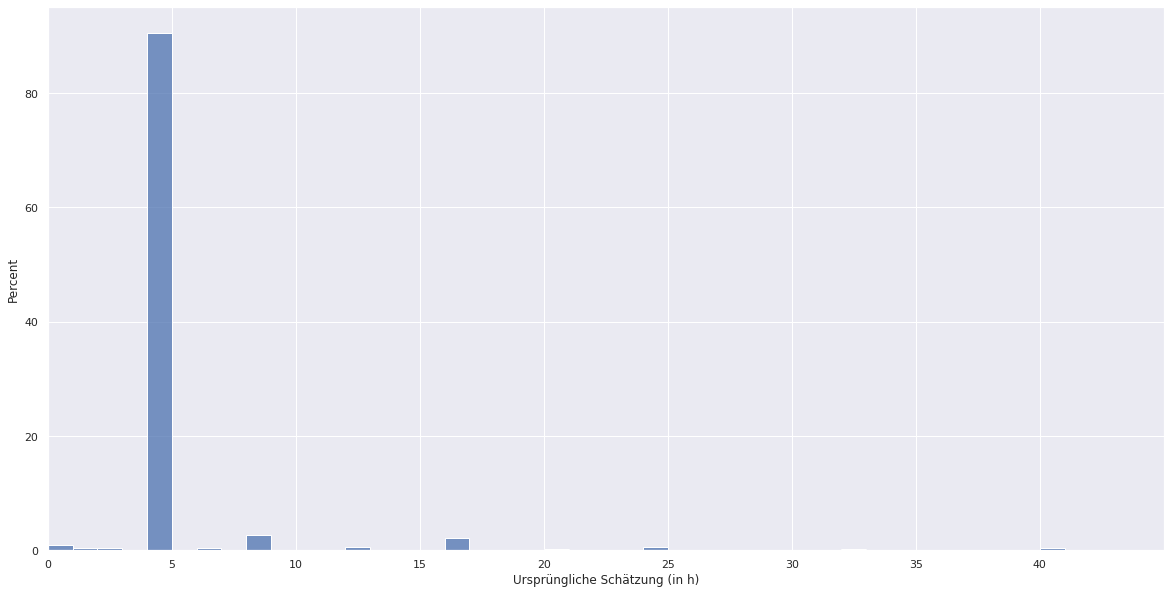

In [128]:
# Ursprüngliche Zeit mit Anteil (%) an Gesamttickets in einem Histogramm visualisieren
# Schnell zu erkennen: 4h ist der Standardwert
g = sns.histplot(data=data_clean, x="Ursprüngliche Schätzung (in h)", binwidth=1, stat="percent")
g.set(xlim=(0, 45))
g.set_xticks(range(0,45,5))

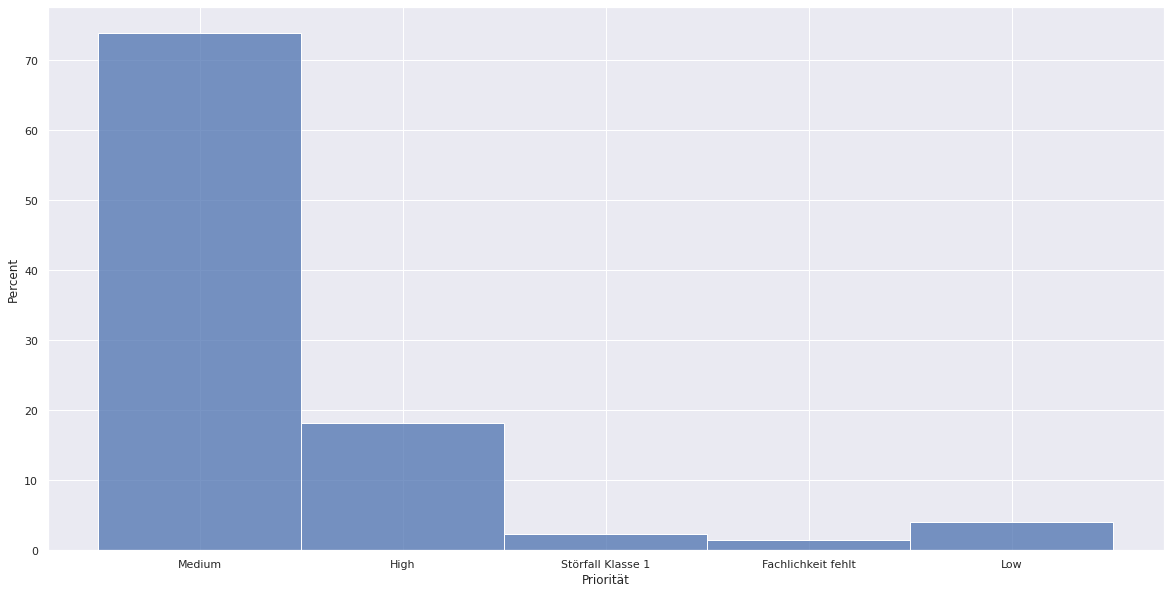

In [129]:
# Priorität mit Anteil (%) an Gesamttickets in einem Histogramm visualisieren
g = sns.histplot(data=data_clean, x="Priorität", stat = "percent")

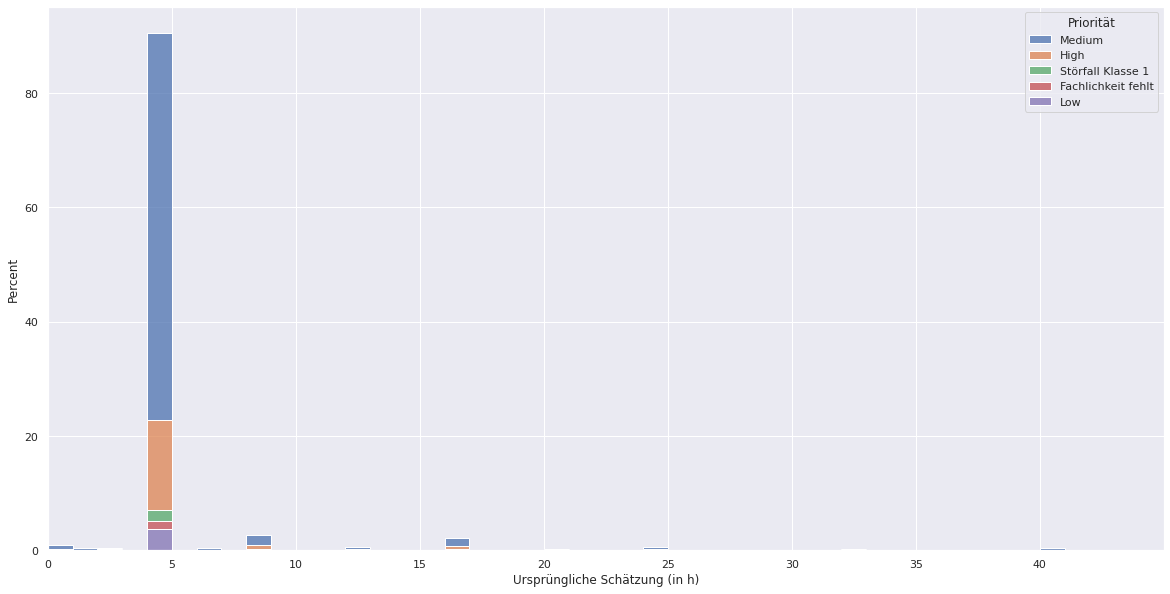

In [130]:
# Ursprüngliche Zeit mit Anteil (%) an Gesamttickets, mit Gruppierung nach Priorität, in einem Histogramm visualisieren
g = sns.histplot(data=data_clean, x="Ursprüngliche Schätzung (in h)", binwidth=1, stat="percent", hue="Priorität", multiple="stack")
g.set(xlim=(0, 45))
g.set_xticks(range(0,45,5))

[None, None]

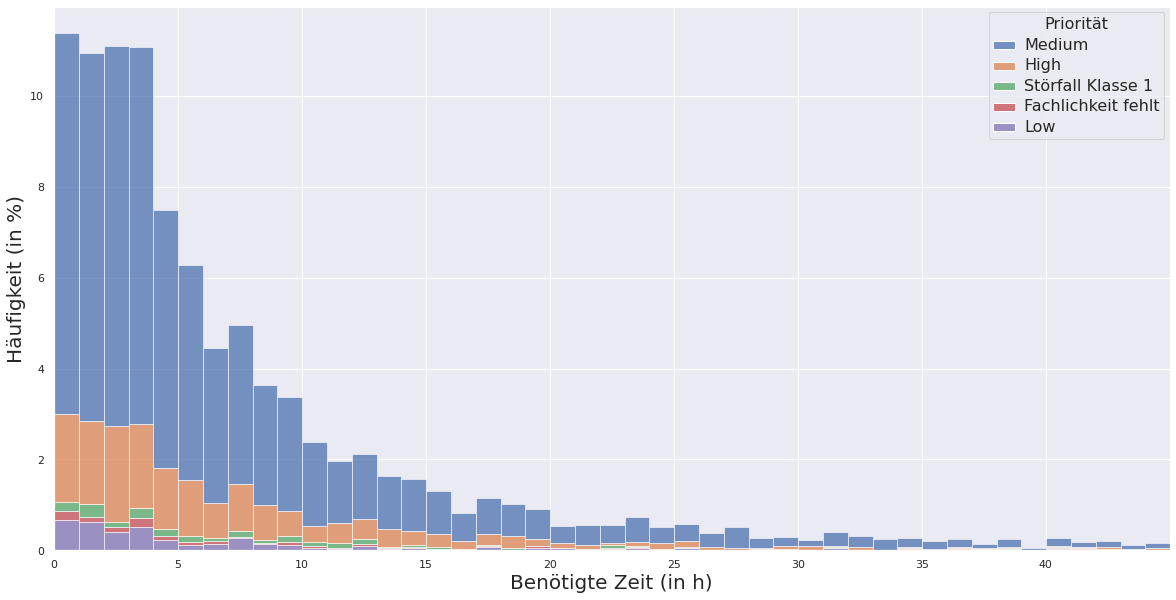

In [131]:
# Benötigte Zeit mit Anteil (%) an Gesamttickets, mit Gruppierung nach Priorität, in einem Histogramm visualisieren
g = sns.histplot(data=data_clean, x="Benötigte Zeit (in h)", binwidth=1, stat="percent", hue="Priorität", multiple="stack")
g.set(xlim=(0, 45))
g.set_xticks(range(0,45,5))
g.set_xlabel("Benötigte Zeit (in h)",fontsize=20)
g.set_ylabel("Häufigkeit (in %)",fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='16')
plt.setp(g.get_legend().get_title(), fontsize='16')

(0.0, 600000.0)

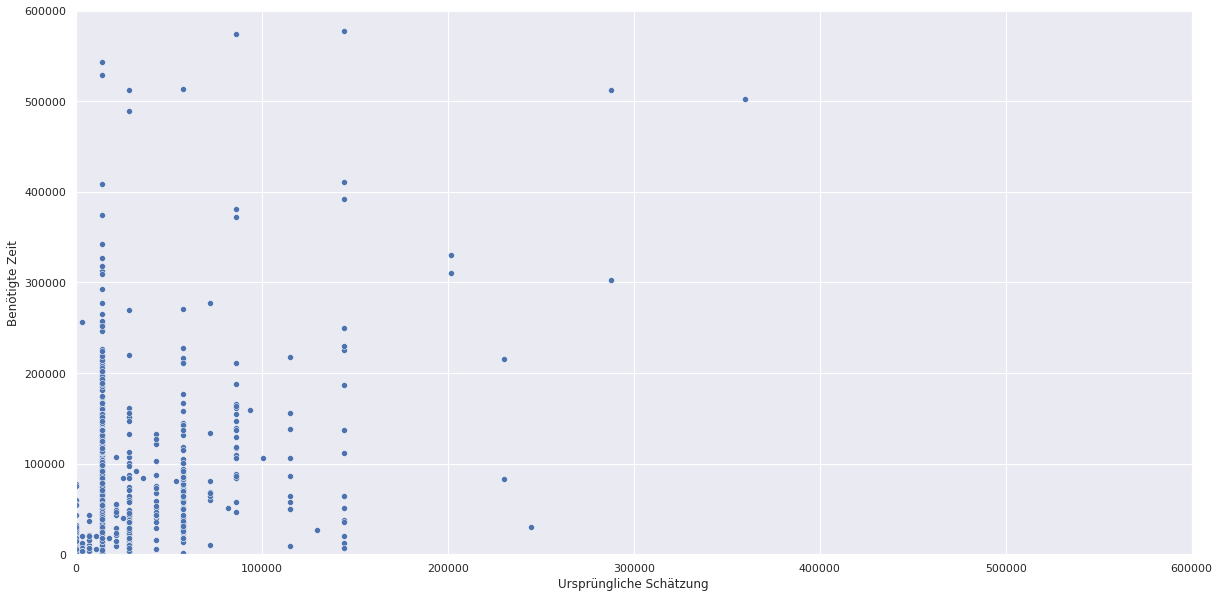

In [132]:
# Visualisierung der Beziehung zwischen benötigter Zeit und ursprünglicher Schätzung 
# -> keine Lineare Abhängigkeit zwischen diesen Variablen zu sehen
g = sns.scatterplot(x="Ursprüngliche Schätzung", y="Benötigte Zeit", data=data_clean)
g.set_xlim(0,600000)
g.set_ylim(0,600000)

(0.0, 600000.0)

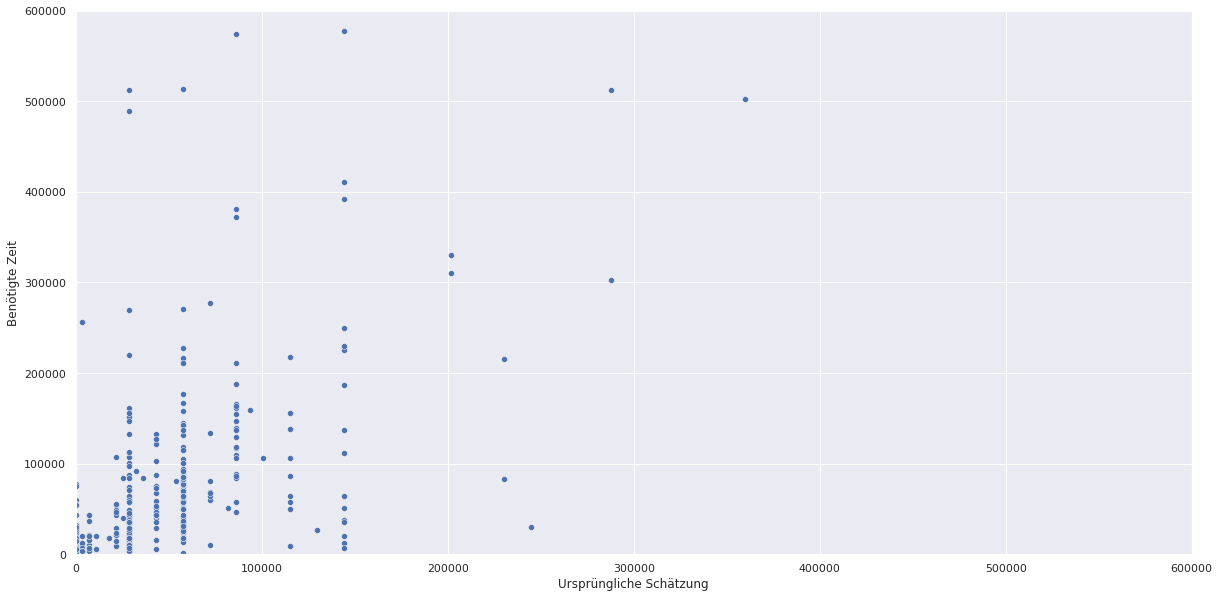

In [133]:
# Visualisierung derselben Beziehung, aber ohne den Standardwert (4h)
# -> kein großer Unterschied zu erkennen
data_plot = data_clean[data_clean["Ursprüngliche Schätzung (in h)"] != 4]
g = sns.scatterplot(x="Ursprüngliche Schätzung", y="Benötigte Zeit", data=data_plot)
g.set_xlim(0,600000)
g.set_ylim(0,600000)

In [134]:
# Um den Zeitverlauf mancher Variablen zu untersuchen, wird ein Zeitmaß benötigt
# MDK-Schlüssel der Tickets soll als Zeitmaß dienen
data_clean["Index"]=data_clean["Schlüssel"].str[4:].astype(int)
data_clean.head()

/tmp/ipykernel_53/879901437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Index"]=data_clean["Schlüssel"].str[4:].astype(int)


,Schlüssel,Zusammenfassung,Ursprüngliche Schätzung,Benötigte Zeit,Priorität,Beschreibung,Ursprüngliche Schätzung (in h),Benötigte Zeit (in h),Index
0,MDK-12997,QP Pflege SGB XI - Prüfbericht(Produktergebnis...,14400.0,43200,Medium,Frage 3.5 (E Frage) wurde im EHB Einrichtung a...,4.0,12.00,12997
1,MDK-12996,QPs - Stichprobenziehung Kurzzeitpflege - Akti...,14400.0,11700,Medium,"Ist: \n\nBogen ""Stichprobenziehung Kurzzeitpfl...",4.0,3.25,12996
2,MDK-12993,QPs - EHB Stichprobenbildung ohne Ergebniserfa...,14400.0,19800,Medium,"IST: \nWird im EHB ""Stichprobenbildung ohne Er...",4.0,5.50,12993
3,MDK-12991,Schneller Wechsel zwischen Aufträgen unterschi...,14400.0,52200,Medium,Getestet gegen QA als michael_meier. Ein schne...,4.0,14.50,12991
4,MDK-12990,[UI] Modaldialog Mitarbeiter löschen verkrafte...,14400.0,8100,Medium,Siehe Screenshot,4.0,2.25,12990


In [135]:
# Für die nächste Visualisierung wird die Differenz zwischen benötigter Zeit und ursprünglicher Schätzung benötigt. 
# Die Differenz wird in einer neuen Spalte gespeichert.
data_clean["Differenz"] = data_clean["Benötigte Zeit"] - data_clean["Ursprüngliche Schätzung"]
data_clean.head()

/tmp/ipykernel_53/598202389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Differenz"] = data_clean["Benötigte Zeit"] - data_clean["Ursprüngliche Schätzung"]


,Schlüssel,Zusammenfassung,Ursprüngliche Schätzung,Benötigte Zeit,Priorität,Beschreibung,Ursprüngliche Schätzung (in h),Benötigte Zeit (in h),Index,Differenz
0,MDK-12997,QP Pflege SGB XI - Prüfbericht(Produktergebnis...,14400.0,43200,Medium,Frage 3.5 (E Frage) wurde im EHB Einrichtung a...,4.0,12.00,12997,28800.0
1,MDK-12996,QPs - Stichprobenziehung Kurzzeitpflege - Akti...,14400.0,11700,Medium,"Ist: \n\nBogen ""Stichprobenziehung Kurzzeitpfl...",4.0,3.25,12996,-2700.0
2,MDK-12993,QPs - EHB Stichprobenbildung ohne Ergebniserfa...,14400.0,19800,Medium,"IST: \nWird im EHB ""Stichprobenbildung ohne Er...",4.0,5.50,12993,5400.0
3,MDK-12991,Schneller Wechsel zwischen Aufträgen unterschi...,14400.0,52200,Medium,Getestet gegen QA als michael_meier. Ein schne...,4.0,14.50,12991,37800.0
4,MDK-12990,[UI] Modaldialog Mitarbeiter löschen verkrafte...,14400.0,8100,Medium,Siehe Screenshot,4.0,2.25,12990,-6300.0


Text(0, 0.5, 'Differenz')

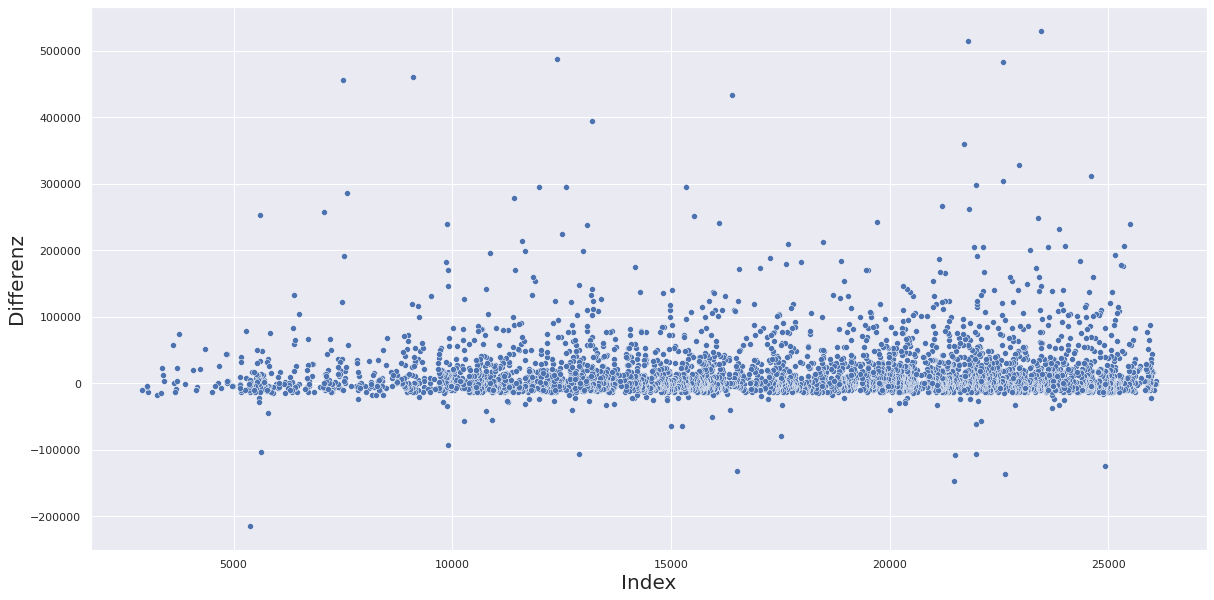

In [136]:
# Visualisierung des zeitlichen Verlaufs der Differenz  
# Zu sehen: 1. Es besteht kein zeiticher Einfluss unter der Annahme, dass die Schlüsselnummern iterativ vergeben werden, 
# 2. Menschliche Schätzungen sind in etwa gleich geblieben, keine Verbesserung über Zeit hinweg erkennbar
g = sns.scatterplot(x="Index", y="Differenz", data=data_clean)
g.set_xlabel("Index",fontsize=20)
g.set_ylabel("Differenz",fontsize=20)

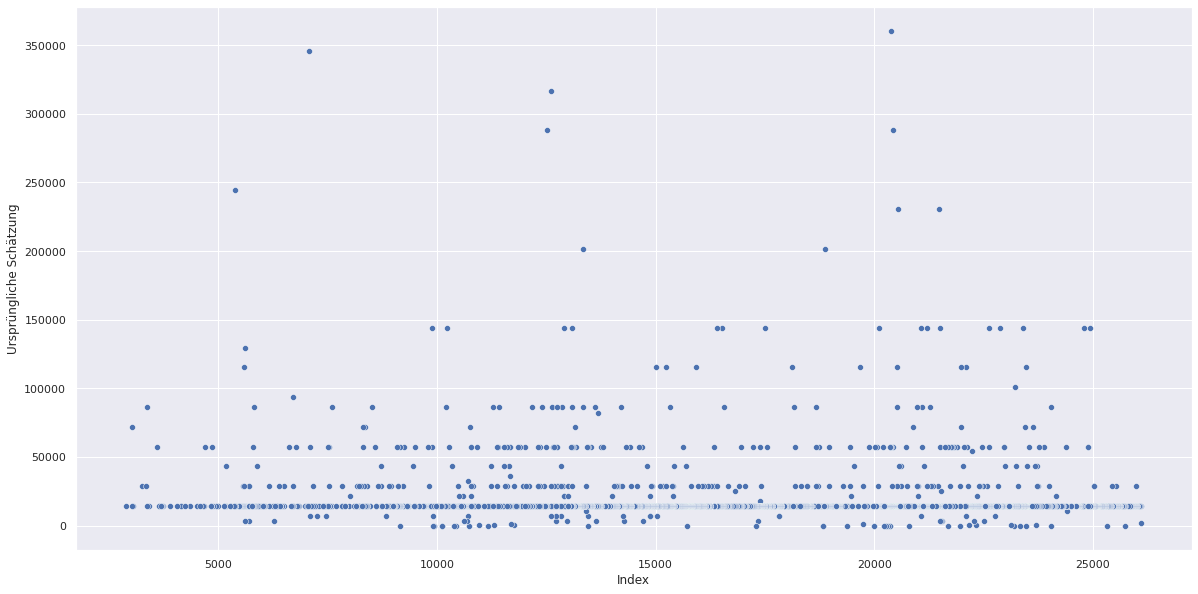

In [137]:
# Visualisierung des zeitlichen Verlaufs der ursprünglichen Schätzung  
g = sns.scatterplot(x="Index", y="Ursprüngliche Schätzung", data=data_clean)

# 2. Textbasierte EDA 

Die textbasierte EDA wird nach den Attributen "Zusammenfassung" und "Beschreibung" aufgeteilt. 
Bis auf wenige Unterschiede, verlaufen die jeweiligen Analysen analog. 

2.1. Zusammenfassung 

2.2. Beschreibung

## 2.1. Zusammenfassung

In [138]:
# Zuerst wird die Verteilung der Wortanzahl der Zusammenfassungen analysiert. Dafür wird der Countvectorizer von 
# scikit-learn verwendet. 

# Ein CountVectorizer wird initialisiert. Die Wörter der Zusammenfassungen werden gezählt und in matrix gespeichert.
word_count = CountVectorizer()
matrix = word_count.fit_transform(data_clean["Zusammenfassung"].values)

# Umwandlung von matrix in einen pandas DataFrame
df = pd.DataFrame(matrix.toarray(), columns=word_count.get_feature_names_out())

# Zusammenzählen der einzelnen Wörter pro Zeile und Entfernen der überschüssigen Spalten.
df["Anzahl"] = df.sum(axis=1)
df = df.loc[:, ["Anzahl"]]

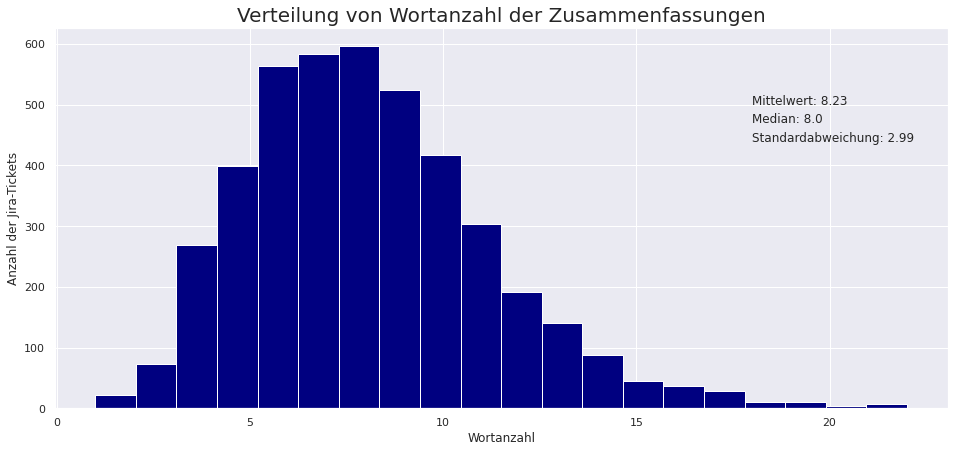

In [139]:
# In Anlehnung an https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# wird hier die Verteilung der Wortanzahl visualisiert. Ergänzend werden statistische Kennzahlen in der Grafik dargestellt.

# Speichern der Wortanzahlen in word_counts
word_counts = df["Anzahl"]

# Visualisierung von word_counts
plt.figure(figsize=(16,7))
plt.hist(word_counts, bins = 20, color="navy")
plt.text(18, 500, "Mittelwert: " + str(round(np.mean(word_counts),2)))
plt.text(18, 470, "Median: " + str(round(np.median(word_counts),2)))
plt.text(18, 440, "Standardabweichung: " + str(round(np.std(word_counts),2))) 
plt.gca().set(ylabel="Anzahl der Jira-Tickets", xlabel="Wortanzahl")
plt.title("Verteilung von Wortanzahl der Zusammenfassungen", fontdict=dict(size=20))
plt.show()

In [140]:
# Teile der Implementierung basieren auf Kapitel 8 des Buches "Machine Learning mit Python und Scikit-Learn und TensorFlow"
# von Raschka, Sebastian und Mirjali, Vahid 

# Anwendung des Bag-of-Words-Modell mit Attribut "Zusammenfassung": Der Text der Zusammenfassung wird als ein numerischer
# Merkmalsvektor repräsentiert, der die Anzahl der Vorkommen jedes einzelnen Wortes in der jeweiligen Zusammenfassung enthält.

# Deklarierung von deutschen Stoppwörtern (wie z.B. "oder", "und")
stop_words_german = stopwords.words("german")

# Im ersten Durchlauf der Wortanalyse war "clone" das häufigst vorkommende Wort -> clone gibt aber nur an, dass es sich 
# um externe Tickets handelt -> keine Aussagekraft
# Da es keinen Einfluss auf die Modellierung haben sollte, soll String "clone" aus dem gesamten Datensatz 
# in der Zusammenfassung entfernt werden. 
stop_words_german.append("clone")

# Die CountVectorizer-Klasse nimmt ein Array mit Textdaten und konstruiert daraus ein Bag-of-words-Modell.
# Dabei wird durch den Aufruf der fit_transform-Methode das Vokabular des Bag-of-words-Modells erstellt und die Dokumente 
# werden in Merkmalsvektoren transformiert. Der Parameter stop_words=stopwords.words("german") konfiguriert den CountVectorizer 
# so, dass deutsche Stoppwörter nicht in die Bag-of-Words aufgenommen werden. 
# Der Parameter max_features=1000 setzt das Maximum des Bag-of-words auf die 1000 häufigsten unterschiedlichen Wörter.
count = CountVectorizer(stop_words=stop_words_german, max_features=1000)

# Die Zusammenfassungen werden dem CountVectorizer übergeben. Der Bag-of-words wird erstellt und die entsprechenden 
# Merkmalsvektoren werden für jeden Artikel erzeugt.
count.fit_transform(data_clean["Zusammenfassung"].values)

# So sieht das gespeicherte Vokabular des Bag-of-words aus. Die Wörter werden alphabetisch sortiert.
words_list = list(count.vocabulary_.keys())
words_list.sort()
words_list[:30]

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '10',
 '11',
 '114',
 '117',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '2006',
 '2019',
 '2021',
 '21',
 '22',
 '2201',
 '2202',
 '2203',
 '2204',
 '23',
 '26',
 '263',
 '29',
 '2hh']

In [141]:
# Bei der bag-of-words fällt auf, dass der Singular und Plural des selben Wortes als unterschiedliche Wörter gezählt werden.
# Um das zu verhindern, wird im folgenden die Stemming-Methode angewandt. 
# (siehe S.277 im Buch von Raschka & Mirjalili)

# Im Folgenden wird der Snowball Stemmer von NLTK (Nature Language Toolkit) verwendet (https://snowballstem.org/).
stemmer = SnowballStemmer("german")

# Um den Snowball Stemmer mit dem CountVectorizer zu kombinieren wird eine spezifische Analyzer Funktion implementiert.
# Dafür wird wie oben der CountVectorizer mit deutschen stopwords initialisiert. In diesem Fall wird aber nur die Analyzer 
# Funktion des CountVectorizers verwendet.
analyzer = CountVectorizer(stop_words=stop_words_german).build_analyzer()

# Analyzer Funktion, die den Stemmer und den Analyzer des CountVectorizers kombiniert:
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# Ein weiterer CountVectorizer, der der spezifischen Analyzer-Funktion übergeben wird. max_features wird wie oben wieder auf 
# 1000 Merkmale gesetzt. max_df ignoriert zusätzlich Wörter, die häufiger als der Durchschnitt vorkommen.
count = CountVectorizer(analyzer=stemmed_words, max_features=1000, max_df=0.5)
matrix = count.fit_transform(data_clean["Zusammenfassung"].values)
words_list = list(count.vocabulary_.keys())
words_list.sort()
words_list[:30]

['00',
 '01',
 '02',
 '04',
 '05',
 '10',
 '11',
 '114',
 '117',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '2006',
 '2019',
 '2021',
 '21',
 '22',
 '2201',
 '2202',
 '2203',
 '23',
 '26',
 '29',
 '2hh',
 '32',
 '325',
 '326']

In [142]:
# Welche Wörter kommen am häufigsten in der Zusammenfassung vor?

# Umwandeln der Bag-of-Words-Matrix in ein pandas Dataframe
counts = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names_out())

# Transponieren der Matrix, damit die verschiedenen Wörter als Zeilen dargestellt werden.
bag_of_words = counts.T

# Vorkommenshäufigkeit der jeweiligen Wörter in einer neuen Spalte namens "Frequenz" angeben
bag_of_words["Frequenz"] = bag_of_words.sum(axis=1)

# In einem neuen Dataframe werden alle weiteren Spalten aussortiert, sodass jedem Wort seine Frequenz über alle 
# Zusammenfassungen hinweg zugewiesen ist.
frequency = bag_of_words.loc[:, ["Frequenz"]]

# Hier sind die 20 Wörter mit der höchsten Frequenz zu sehen. 
top20 = frequency.sort_values(by="Frequenz", ascending=False).head(20)
top20

,Frequenz
qps,628
prufbericht,415
qpa,404
auftrag,289
ehb,286
fehl,273
prufbog,265
stammdat,254
moglich,238
kapitel,210


Text(0.5, 1.0, 'Anzahl der 20 häufigsten Stammwörter')

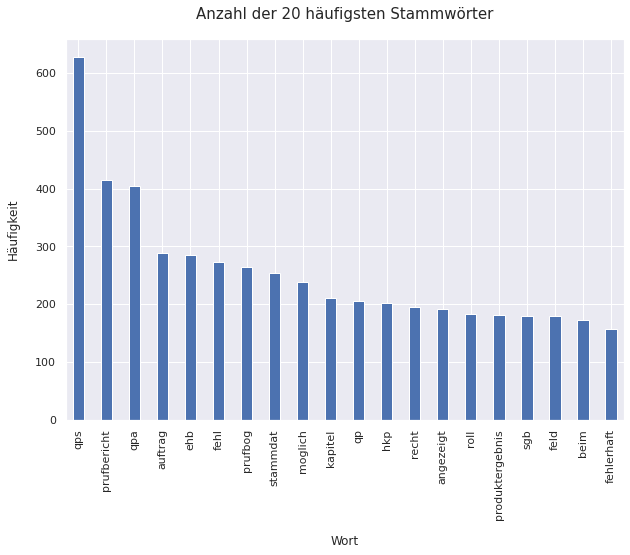

In [143]:
# Visualisierung der 20 häufigsten Wörter in der Zusammenfassung
top20.plot(kind="bar", figsize=(10,7), width=0.4, legend=None)
plt.ylabel("Häufigkeit", fontsize=12, labelpad=15)
plt.xlabel("Wort", fontsize=12, labelpad=15)
plt.title("Anzahl der 20 häufigsten Stammwörter", fontsize=15, pad=20)

## 2.2. Beschreibung 

In [ ]:
# Zu Anfang muss die Spalte "Beschreibung" angepasst bzw. gecleaned werden. 
# Regex übernommen und adaptiert von https://ihateregex.io/

# Data Beschreibung muss ein String sein, bevor analysiert werden kann.
data_clean["Beschreibung"] = data_clean["Beschreibung"].astype(str)

# Information über bestehendes Bild in einer weiteren Spalte speichern
data_clean["Beschreibung hat Bild"] = data_clean["Beschreibung"].str.contains("!image")

# Bilder rausfiltern und in Beschreibung2 speichern
data_clean["Beschreibung2"] = data_clean["Beschreibung"].str.replace("!image.*|thumbnail!","")

# Telefonnummern rausfiltern und in Beschreibung2 speichern
data_clean["Beschreibung2"] = data_clean["Beschreibung2"].str.replace('[\+]?[(]?[0-9]{3}[)]?[-\s\.]?[0-9]{3}[-\s\.]?[0-9]{4,6}',"")

# Zahlen rausfiltern und in Beschreibung2 speichern
data_clean["Beschreibung2"] = data_clean["Beschreibung2"].str.replace('[0-9]+',"")

# URLs rausfiltern und in Beschreibung2 speichern
data_clean["Beschreibung2"] = data_clean["Beschreibung2"].str.replace('https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)',"")

# Emailadressen rausfiltern und in Beschreibung2 speichern 
data_clean["Beschreibung2"] = data_clean["Beschreibung2"].str.replace('(([^<>()\[\]\\.,;:\s@"]+(\.[^<>()\[\]\\.,;:\s@"]+)*)|(".+"))@((\[[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}])|(([a-zA-Z\-0-9]+\.)+[a-zA-Z]{2,}))',"")

data_clean.head()

/tmp/ipykernel_53/3248556536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Beschreibung"] = data_clean["Beschreibung"].astype(str)
/tmp/ipykernel_53/3248556536.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Beschreibung hat Bild"] = data_clean["Beschreibung"].str.contains("!image")
/tmp/ipykernel_53/3248556536.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  data_clean["Beschreibung2"] = data_clean["Beschreibung"].str.r

In [ ]:
# Hier wird nltk words tokenizer verwendet, um Personen im Beschreibungstext finden und mit Wort "Person" zu ersetzen 
# Code von https://unbiased-coder.com/extract-names-python-nltk/ und 
# https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-string-column-of-a-pandas-dataframe

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
        
#def find_and_replace_names(text):
#    nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
#    for nltk_result in nltk_results:
#        if type(nltk_result) == Tree:
#            name = ''
#            for nltk_result_leaf in nltk_result.leaves():
#               name += nltk_result_leaf[0] + ' '
#            print ('Type: ', nltk_result.label(), 'Name: ', name)
#            if nltk_result.label() == "PERSON":
#                text = text.replace(name, "Person ")
#    return text
    
#data_clean["Beschreibung2"] = data_clean["Beschreibung2"].apply(lambda x: find_and_replace_names(x))
#data_clean["Beschreibung2"]

# -> Personen wurden nicht richtig erkannt, daher wurder Schritt nicht angewendet 

In [ ]:
# Analog: Verteilung der Wortanzahl der Beschreibungen analysieren mit Countvectorizer von scikit-learn

word_count = CountVectorizer()
matrix2 = word_count.fit_transform(data_clean["Beschreibung2"].values)
df2 = pd.DataFrame(matrix2.toarray(), columns=word_count.get_feature_names_out())
df2["Anzahl"] = df2.sum(axis=1)
df2 = df2.loc[:, ["Anzahl"]]

In [ ]:
# Analog: Visualisierung der Verteilung von Wortanzahl in der Beschreibung

word_counts2 = df2["Anzahl"]

plt.figure(figsize=(16,4))
plt.hist(word_counts2, bins = 500, color="navy")
plt.text(200, 340, "Mittelwert: " + str(round(np.mean(word_counts2),2)))
plt.text(200, 310, "Median: " + str(round(np.median(word_counts2),2)))
plt.text(200, 280, "Standardabweichung: " + str(round(np.std(word_counts2),2))) 
plt.gca().set(xlim=(0,400),ylabel="Anzahl der Jira-Tickets", xlabel="Wortanzahl")
plt.title("Verteilung von Wortanzahl der Beschreibungen", fontdict=dict(size=20))
plt.show()

In [ ]:
# Analog: Implementierung des Bag-of-Words-Modell für Beschreibung

count = CountVectorizer(stop_words=stopwords.words("german"), max_features=1000)
count.fit_transform(data_clean["Beschreibung2"].values)

# Alphabetisch sortierte Vokabular des Bag-of-words.
words_list2 = list(count.vocabulary_.keys())
words_list2.sort()
words_list2[:30]

In [ ]:
# Analog: Implementierung des Bag-of-Words-Modells mit Stemming Methode für Beschreibung

stemmer = SnowballStemmer("german")
analyzer = CountVectorizer(stop_words=stopwords.words("german")).build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

count = CountVectorizer(analyzer=stemmed_words, max_features=1000, max_df=0.5)
matrix2 = count.fit_transform(data_clean["Beschreibung2"].values)
words_list2 = list(count.vocabulary_.keys())
words_list2.sort()
words_list2[:30]

In [ ]:
# Analog: Welche Wörter kommen am häufigsten in der Beschreibung vor?

counts = pd.DataFrame(matrix2.toarray(), columns=count.get_feature_names_out())
bag_of_words = counts.T
bag_of_words["Frequenz"] = bag_of_words.sum(axis=1)
frequency = bag_of_words.loc[:, ["Frequenz"]]
top20 = frequency.sort_values(by="Frequenz", ascending=False).head(20)
top20

In [ ]:
# Wort at untersuchen, um sicherzugehen, dass nicht @ gemeint ist. 
# Zu erkennen: "at" ist Teil der abgebildeten Java exceptions
#data_clean.iloc[counts[counts["at"]>0].index]["Beschreibung2"].tolist()

In [ ]:
# Visualisierung der 20 häufigsten Wörter in der Beschreibung
top20.plot(kind="bar", figsize=(10,7), width=0.4, legend=None)
plt.ylabel("Häufigkeit", fontsize=12, labelpad=15)
plt.xlabel("Wort", fontsize=12, labelpad=15)
plt.title("Anzahl der 20 häufigsten Stammwörter", fontsize=15, pad=20)

In [ ]:
# Exportieren der aufbereiteten Daten als csv-Datei
data_clean.to_csv("data_post_eda.csv")

In [ ]:
# Exportieren der aufbereiteten Daten als Excel-Datei
data_clean.to_excel("data_post_eda.xlsx")